In [1]:
from typing import Dict, Tuple
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import csv

In [2]:
config = {
    "device": "cuda",
    "n_epoch": 200,
    "batch_size": 256,
    "n_T": 400,
    "n_classes": 10,
    "n_feat": 128,
    "lrate": 1e-4,
    "save_model": True,
    "save_dir": "./saved_models/",
    "ws_test": [0.0, 0.5, 2.0],
    "betas": (1e-4, 0.02),
    "drop_prob": 0.1,
    "dataset_path": "./dataset/",
    "image_size": (3, 32, 32),
    "num_workers": 4
}

In [3]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False):
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        self.model = nn.Sequential(
            ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        )

    def forward(self, x):
        x = x.view(-1, self.model[0].in_features)
        return self.model(x)

class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat, n_classes):
        super(ContextUnet, self).__init__()
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d(8), nn.GELU())
        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_classes, n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 8, 8),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, in_channels, 3, 1, 1),
        )

    def one_hot(self, c, num_classes):
        return torch.zeros(len(c), num_classes, device=c.device).scatter_(1, c.view(-1, 1), 1.0)

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        c = self.one_hot(c, self.contextembed1.model[0].in_features)
        c = c * context_mask[:, None]

        cemb1 = self.contextembed1(c).view(-1, self.contextembed1.model[0].out_features, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.timeembed1.model[0].out_features, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.contextembed2.model[0].out_features, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.timeembed2.model[0].out_features, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down2)
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        return self.out(torch.cat((up3, x), 1))

In [4]:
def ddpm_schedules(beta1, beta2, T):

    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "log_alpha_t": log_alpha_t,
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [5]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))
    
    def sample_single(self, n_sample, size, device, c, guide_w = 0.0):
           
        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
       
        #c = c.repeat(int(n_sample/c.shape[0]))
    
        # don't drop context at test time
        context_mask = torch.zeros(1).to(device)
        if c.dim()== 1:
            c = c.repeat(2)
        else:
            c = c.repeat(2,1)

        context_mask = context_mask.repeat(2)

        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, * size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store
    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [6]:
def plot_loss(loss_history_per_iteration, loss_history_per_epoch):
    # Plotting Iteration-wise Loss
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)  # First subplot (Iteration-wise Loss)
    plt.plot(loss_history_per_iteration, label="Loss (per iteration)", color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss per Iteration")
    plt.legend()
    plt.grid()

    # Plotting Epoch-wise Loss (average loss per epoch)
    plt.subplot(1, 2, 2)  # Second subplot (Epoch-wise Loss)
    plt.plot(loss_history_per_epoch, label="Loss (per epoch)", color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.legend()
    plt.grid()

    # Show both plots
    plt.tight_layout()
    plt.show()

def save_loss_history_to_csv(save_dir, loss_history_per_iteration, loss_history_per_epoch):
    # Save the loss history to a CSV file
    csv_file_path = os.path.join(save_dir, "loss_history.csv")
    
    # Open the CSV file in write mode
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration Loss', 'Epoch Loss'])  # Header row
        
        # Determine the maximum number of iterations or epochs to ensure all data is written
        max_len = max(len(loss_history_per_iteration), len(loss_history_per_epoch))
        
        # Write the iteration-wise and epoch-wise losses
        for i in range(max_len):
            iteration_loss = loss_history_per_iteration[i] if i < len(loss_history_per_iteration) else ""
            epoch_loss = loss_history_per_epoch[i] if i < len(loss_history_per_epoch) else ""
            writer.writerow([iteration_loss, epoch_loss])
    
    print(f"Loss history saved to {csv_file_path}")

In [7]:
def train_model(config):
    device = config["device"]

    if not os.path.exists(config["save_dir"]):
        os.makedirs(config["save_dir"])

    model = ContextUnet(in_channels=3, n_feat=config["n_feat"], n_classes=config["n_classes"])
    ddpm = DDPM(
        nn_model=model,
        betas=config["betas"],
        n_T=config["n_T"],
        device=device,
        drop_prob=config["drop_prob"],
    ).to(device)

    tf = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.CIFAR10(config["dataset_path"], train=True, download=True, transform=tf)
    dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True, num_workers=config["num_workers"])

    optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["lrate"])
    loss_history_per_iteration = []
    loss_history_per_epoch = []

    for epoch in range(config["n_epoch"]):
        ddpm.train()
        optimizer.param_groups[0]["lr"] = config["lrate"] * (1 - epoch / config["n_epoch"])

        epoch_loss = 0  # Variable to accumulate loss for the epoch
        num_batches = 0  # To count the number of batches in the epoch

        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
        for x, c in pbar:
            x, c = x.to(device), c.to(device)
            optimizer.zero_grad()
            loss = ddpm(x, c)
            loss.backward()
            optimizer.step()

            loss_history_per_iteration.append(loss.item())  # Track loss for each iteration

            epoch_loss += loss.item()  # Accumulate epoch loss
            num_batches += 1

            pbar.set_description(f"Epoch {epoch + 1} | Loss: {loss.item():.4f}")

        # Calculate the average loss for the epoch and store it
        avg_epoch_loss = epoch_loss / num_batches
        loss_history_per_epoch.append(avg_epoch_loss)

        # Save model checkpoint
        if config["save_model"] and (epoch % 5 == 0 or epoch == config["n_epoch"] - 1):
            torch.save(ddpm.state_dict(), os.path.join(config["save_dir"], f"model_epoch_{epoch}.pth"))

    # Plot the loss history after training
    plot_loss(loss_history_per_iteration, loss_history_per_epoch)

    # Save loss history to CSV
    save_loss_history_to_csv(config["save_dir"], loss_history_per_iteration, loss_history_per_epoch)

    return ddpm

100%|██████████| 170498071/170498071 [00:03<00:00, 53985474.03it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset/


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 101:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 102:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 103:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 104:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 105:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 106:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 107:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 108:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 109:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 110:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 111:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 112:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 113:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 114:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 115:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 116:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 117:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 118:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 119:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 120:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 121:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 122:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 123:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 124:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 126:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 127:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 128:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 129:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 132:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 133:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 134:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 135:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 136:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 137:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 138:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 139:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 140:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 141:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 142:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 143:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 144:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 145:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 146:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 147:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 148:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 149:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 150:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 151:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 152:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 153:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 154:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 155:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 156:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 157:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 158:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 159:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 160:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 161:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 162:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 163:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 164:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 165:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 166:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 167:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 168:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 169:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 170:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 171:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 172:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 173:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 174:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 175:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 176:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 177:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 178:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 179:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 180:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 181:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 182:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 183:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 184:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 185:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 186:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 187:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 188:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 189:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 190:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 191:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 192:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 193:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 194:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 195:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 196:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 197:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 198:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 199:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 200:   0%|          | 0/196 [00:00<?, ?it/s]

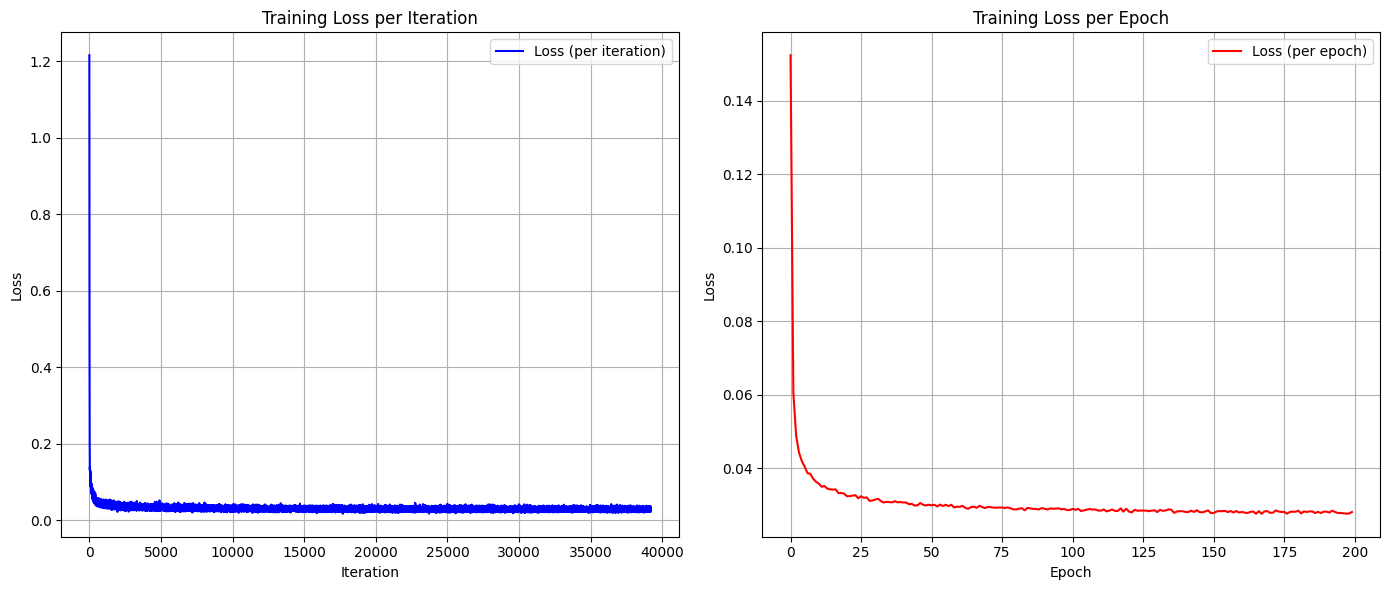

Loss history saved to ./saved_models/loss_history.csv


In [8]:
ddpm = train_model(config)

In [9]:
# def plot_loss(loss_history):
#     plt.figure(figsize=(10, 6))
#     plt.plot(loss_history, label="Loss")
#     plt.xlabel("Iteration")
#     plt.ylabel("Loss")
#     plt.title("Training Loss")
#     plt.legend()
#     plt.grid()
#     plt.show()
    
# def train_model(config):
#     device = config["device"]

#     if not os.path.exists(config["save_dir"]):
#         os.makedirs(config["save_dir"])

#     model = ContextUnet(in_channels=3, n_feat=config["n_feat"], n_classes=config["n_classes"])
#     ddpm = DDPM(
#         nn_model=model,
#         betas=config["betas"],
#         n_T=config["n_T"],
#         device=device,
#         drop_prob=config["drop_prob"],
#     ).to(device)

#     tf = transforms.Compose([transforms.ToTensor()])
#     dataset = datasets.CIFAR10(config["dataset_path"], train=True, download=True, transform=tf)
#     dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True, num_workers=config["num_workers"])

#     optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["lrate"])
#     loss_history = []

#     for epoch in range(config["n_epoch"]):
#         ddpm.train()
#         optimizer.param_groups[0]["lr"] = config["lrate"] * (1 - epoch / config["n_epoch"])

#         pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
#         for x, c in pbar:
#             x, c = x.to(device), c.to(device)
#             optimizer.zero_grad()
#             loss = ddpm(x, c)
#             loss.backward()
#             optimizer.step()
#             loss_history.append(loss.item())
#             pbar.set_description(f"Epoch {epoch + 1} | Loss: {loss.item():.4f}")

#         if config["save_model"] and (epoch % 5 == 0 or epoch == config["n_epoch"] - 1):
#             torch.save(ddpm.state_dict(), os.path.join(config["save_dir"], f"model_epoch_{epoch}.pth"))

#     plot_loss(loss_history)
#     return ddpm

In [10]:
# ddpm = train_model(config)

In [11]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
train = CIFAR10("./datapics", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = CIFAR10("./datapics", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 170498071/170498071 [00:02<00:00, 78752361.48it/s]


Extracting ./datapics/cifar-10-python.tar.gz to ./datapics
Files already downloaded and verified


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def plot_forward_and_backward(ddpm, sample_image, n_steps=10):
    """
    Plots the forward and backward diffusion process and computes quality metrics.
    
    Parameters:
    - ddpm: The trained DDPM model.
    - sample_image: A single input image tensor (C, H, W).
    - n_steps: Number of timesteps to visualize.
    """
    sample_image = sample_image.unsqueeze(0).to(ddpm.device)  # Add batch dimension
    
    # Get forward process images
    timesteps = np.linspace(0, ddpm.n_T, n_steps, dtype=int)
    forward_images = []
    x_t = sample_image.clone()
    noises = []
    with torch.no_grad():
        for t in timesteps:
            noise = torch.randn_like(sample_image).to(ddpm.device)
            noises.append(noise)
            beta = ddpm.sqrtmab[t]  # Noise multiplier
            alpha = ddpm.sqrtab[t]  # Signal multiplier
            x_t = alpha * sample_image + beta * noise
            forward_images.append(x_t.squeeze(0))

    # Get backward process images
    backward_images = []
    x_t = forward_images[-1].unsqueeze(0)  # Start with the noisy image from forward process
    with torch.no_grad():
        for t in reversed(range(1, ddpm.n_T + 1)):
            z = torch.randn_like(x_t).to(ddpm.device) if t > 1 else 0
            eps = ddpm.nn_model(x_t, torch.tensor([0]).to(ddpm.device), torch.tensor([t/ddpm.n_T]).to(ddpm.device), torch.tensor([0]).to(ddpm.device))
            x_t = ddpm.oneover_sqrta[t] * (x_t - eps * ddpm.mab_over_sqrtmab[t]) + ddpm.sqrt_beta_t[t] * z
            if t in timesteps:
                backward_images.append(x_t.squeeze(0).detach())

    # Ensure backward images match the number of timesteps
    if len(backward_images) < len(timesteps):
        backward_images.append(x_t.squeeze(0).detach())

    # Compute quality metrics
    mse_values, ssim_values, psnr_values = [], [], []
    for i, img in enumerate(backward_images):
        original = sample_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        reconstructed = img.permute(1, 2, 0).cpu().numpy()

        mse = np.mean((original - reconstructed) ** 2)
        ssim_val = ssim(
            original, reconstructed, 
            multichannel=True, 
            data_range=original.max() - original.min(),
            win_size=3  # Adjusted window size
        )
        psnr_val = psnr(original, reconstructed, data_range=original.max() - original.min())

        mse_values.append(mse)
        ssim_values.append(ssim_val)
        psnr_values.append(psnr_val)

    # Plot forward and backward images
    fig, axes = plt.subplots(2, n_steps, figsize=(n_steps * 2, 6))
    for i, img in enumerate(forward_images):
        axes[0, i].imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"t={timesteps[i]}")

    for i, img in enumerate(backward_images):
        axes[1, i].imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"MSE={mse_values[i]:.2f}\nSSIM={ssim_values[i]:.2f}\nPSNR={psnr_values[i]:.2f}")

    axes[0, 0].set_ylabel("Forward")
    axes[1, 0].set_ylabel("Backward")
    plt.tight_layout()
    plt.show()

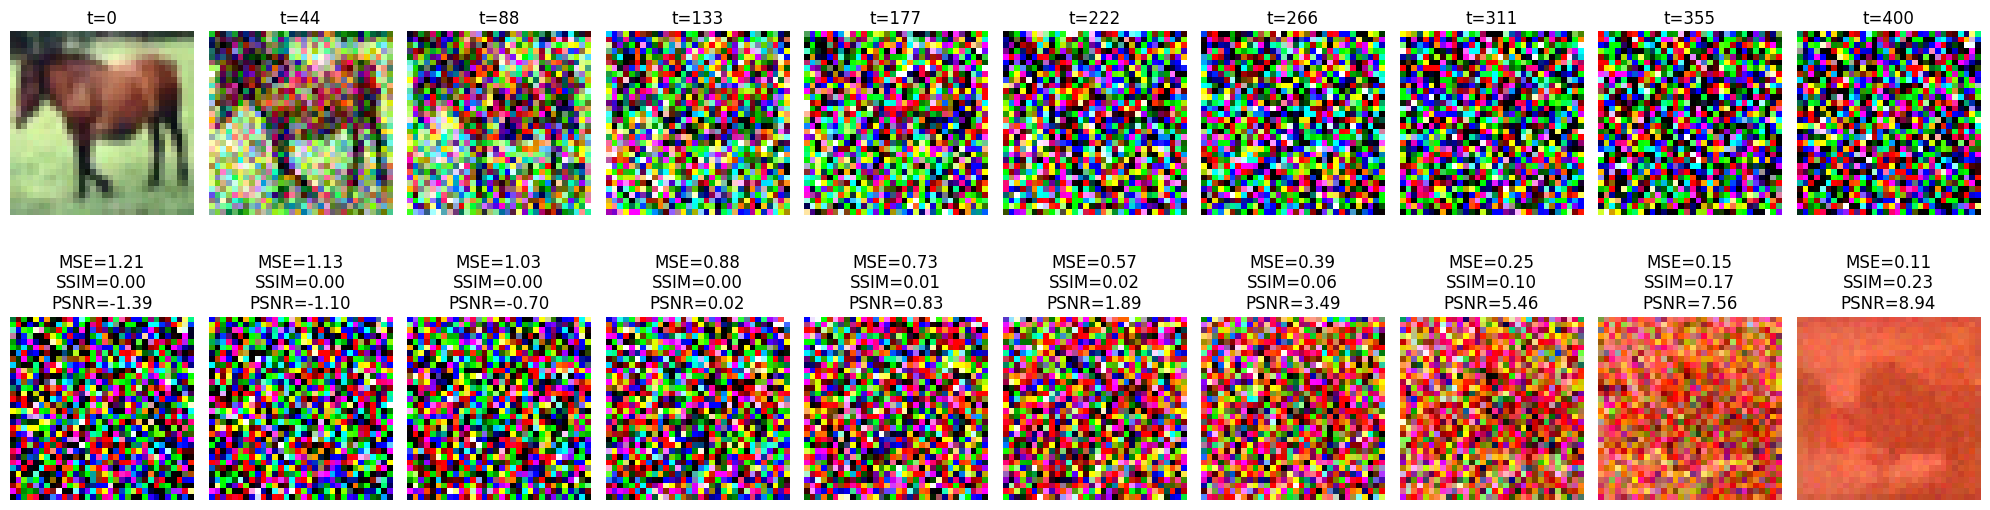

In [13]:
plot_forward_and_backward(ddpm, train[7][0])

In [14]:
def plot_samples_per_class(ddpm, dataset, class_names, n_classes=10, n_steps=10):
    """
    Plots one sample per class for CIFAR-10 dataset, showing forward and backward processes with quality metrics.
    
    Parameters:
    - ddpm: The trained DDPM model.
    - dataset: The CIFAR-10 dataset.
    - class_names: List of class names for CIFAR-10.
    - n_classes: Number of classes (default is 10 for CIFAR-10).
    - n_steps: Number of timesteps to visualize.
    """
    samples = []
    labels = []

    # Find one sample per class
    for img, label in dataset:
        if label not in labels:
            samples.append((img, label))
            labels.append(label)
        if len(labels) == n_classes:
            break

    fig, axes = plt.subplots(n_classes, n_steps * 2 + 2, figsize=((n_steps * 2 + 2) * 2, n_classes * 3))

    for i, (img, label) in enumerate(samples):
        img = img.unsqueeze(0).to(ddpm.device)  # Add batch dimension

        # Forward process
        timesteps = np.linspace(0, ddpm.n_T, n_steps, dtype=int)
        forward_images = []
        x_t = img.clone()
        noises = []
        with torch.no_grad():
            for t in timesteps:
                noise = torch.randn_like(img).to(ddpm.device)
                noises.append(noise)
                beta = ddpm.sqrtmab[t]  # Noise multiplier
                alpha = ddpm.sqrtab[t]  # Signal multiplier
                x_t = alpha * img + beta * noise
                forward_images.append(x_t.squeeze(0))

        # Backward process
        backward_images = []
        x_t = forward_images[-1].unsqueeze(0)  # Start with the noisy image from forward process
        with torch.no_grad():
            for t in reversed(range(1, ddpm.n_T + 1)):
                z = torch.randn_like(x_t).to(ddpm.device) if t > 1 else 0
                eps = ddpm.nn_model(x_t, torch.tensor([label]).to(ddpm.device), torch.tensor([t / ddpm.n_T]).to(ddpm.device), torch.tensor([0]).to(ddpm.device))
                x_t = ddpm.oneover_sqrta[t] * (x_t - eps * ddpm.mab_over_sqrtmab[t]) + ddpm.sqrt_beta_t[t] * z
                if t in timesteps:
                    backward_images.append(x_t.squeeze(0).detach())

        # Ensure backward images match the number of timesteps
        if len(backward_images) < len(timesteps):
            backward_images.append(x_t.squeeze(0).detach())

        # Compute quality metrics
        mse_values, ssim_values, psnr_values = [], [], []
        for j, img_b in enumerate(backward_images):
            original = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
            reconstructed = img_b.permute(1, 2, 0).cpu().numpy()

            mse = np.mean((original - reconstructed) ** 2)
            ssim_val = ssim(
                original, reconstructed, 
                multichannel=True, 
                data_range=original.max() - original.min(),
                win_size=3  # Adjusted window size
            )
            psnr_val = psnr(original, reconstructed, data_range=original.max() - original.min())

            mse_values.append(mse)
            ssim_values.append(ssim_val)
            psnr_values.append(psnr_val)

        # Plot forward images
        for j, img_f in enumerate(forward_images):
            axes[i, j].imshow(img_f.permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(f"t={timesteps[j]}")

        # Plot backward images
        for j, img_b in enumerate(backward_images):
            axes[i, j + n_steps].imshow(img_b.permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[i, j + n_steps].axis('off')
            axes[i, j + n_steps].set_title(f"MSE={mse_values[j]:.2f}\nSSIM={ssim_values[j]:.2f}\nPSNR={psnr_values[j]:.2f}")

        # Plot the original image
        axes[i, -2].imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes[i, -2].axis('off')
        axes[i, -2].set_title("Original")

        # Plot the final backward image
        axes[i, -1].imshow(backward_images[-1].permute(1, 2, 0).cpu().numpy())
        axes[i, -1].axis('off')
        axes[i, -1].set_title(f"Class {class_names[label]}")

    plt.tight_layout()
    plt.show()

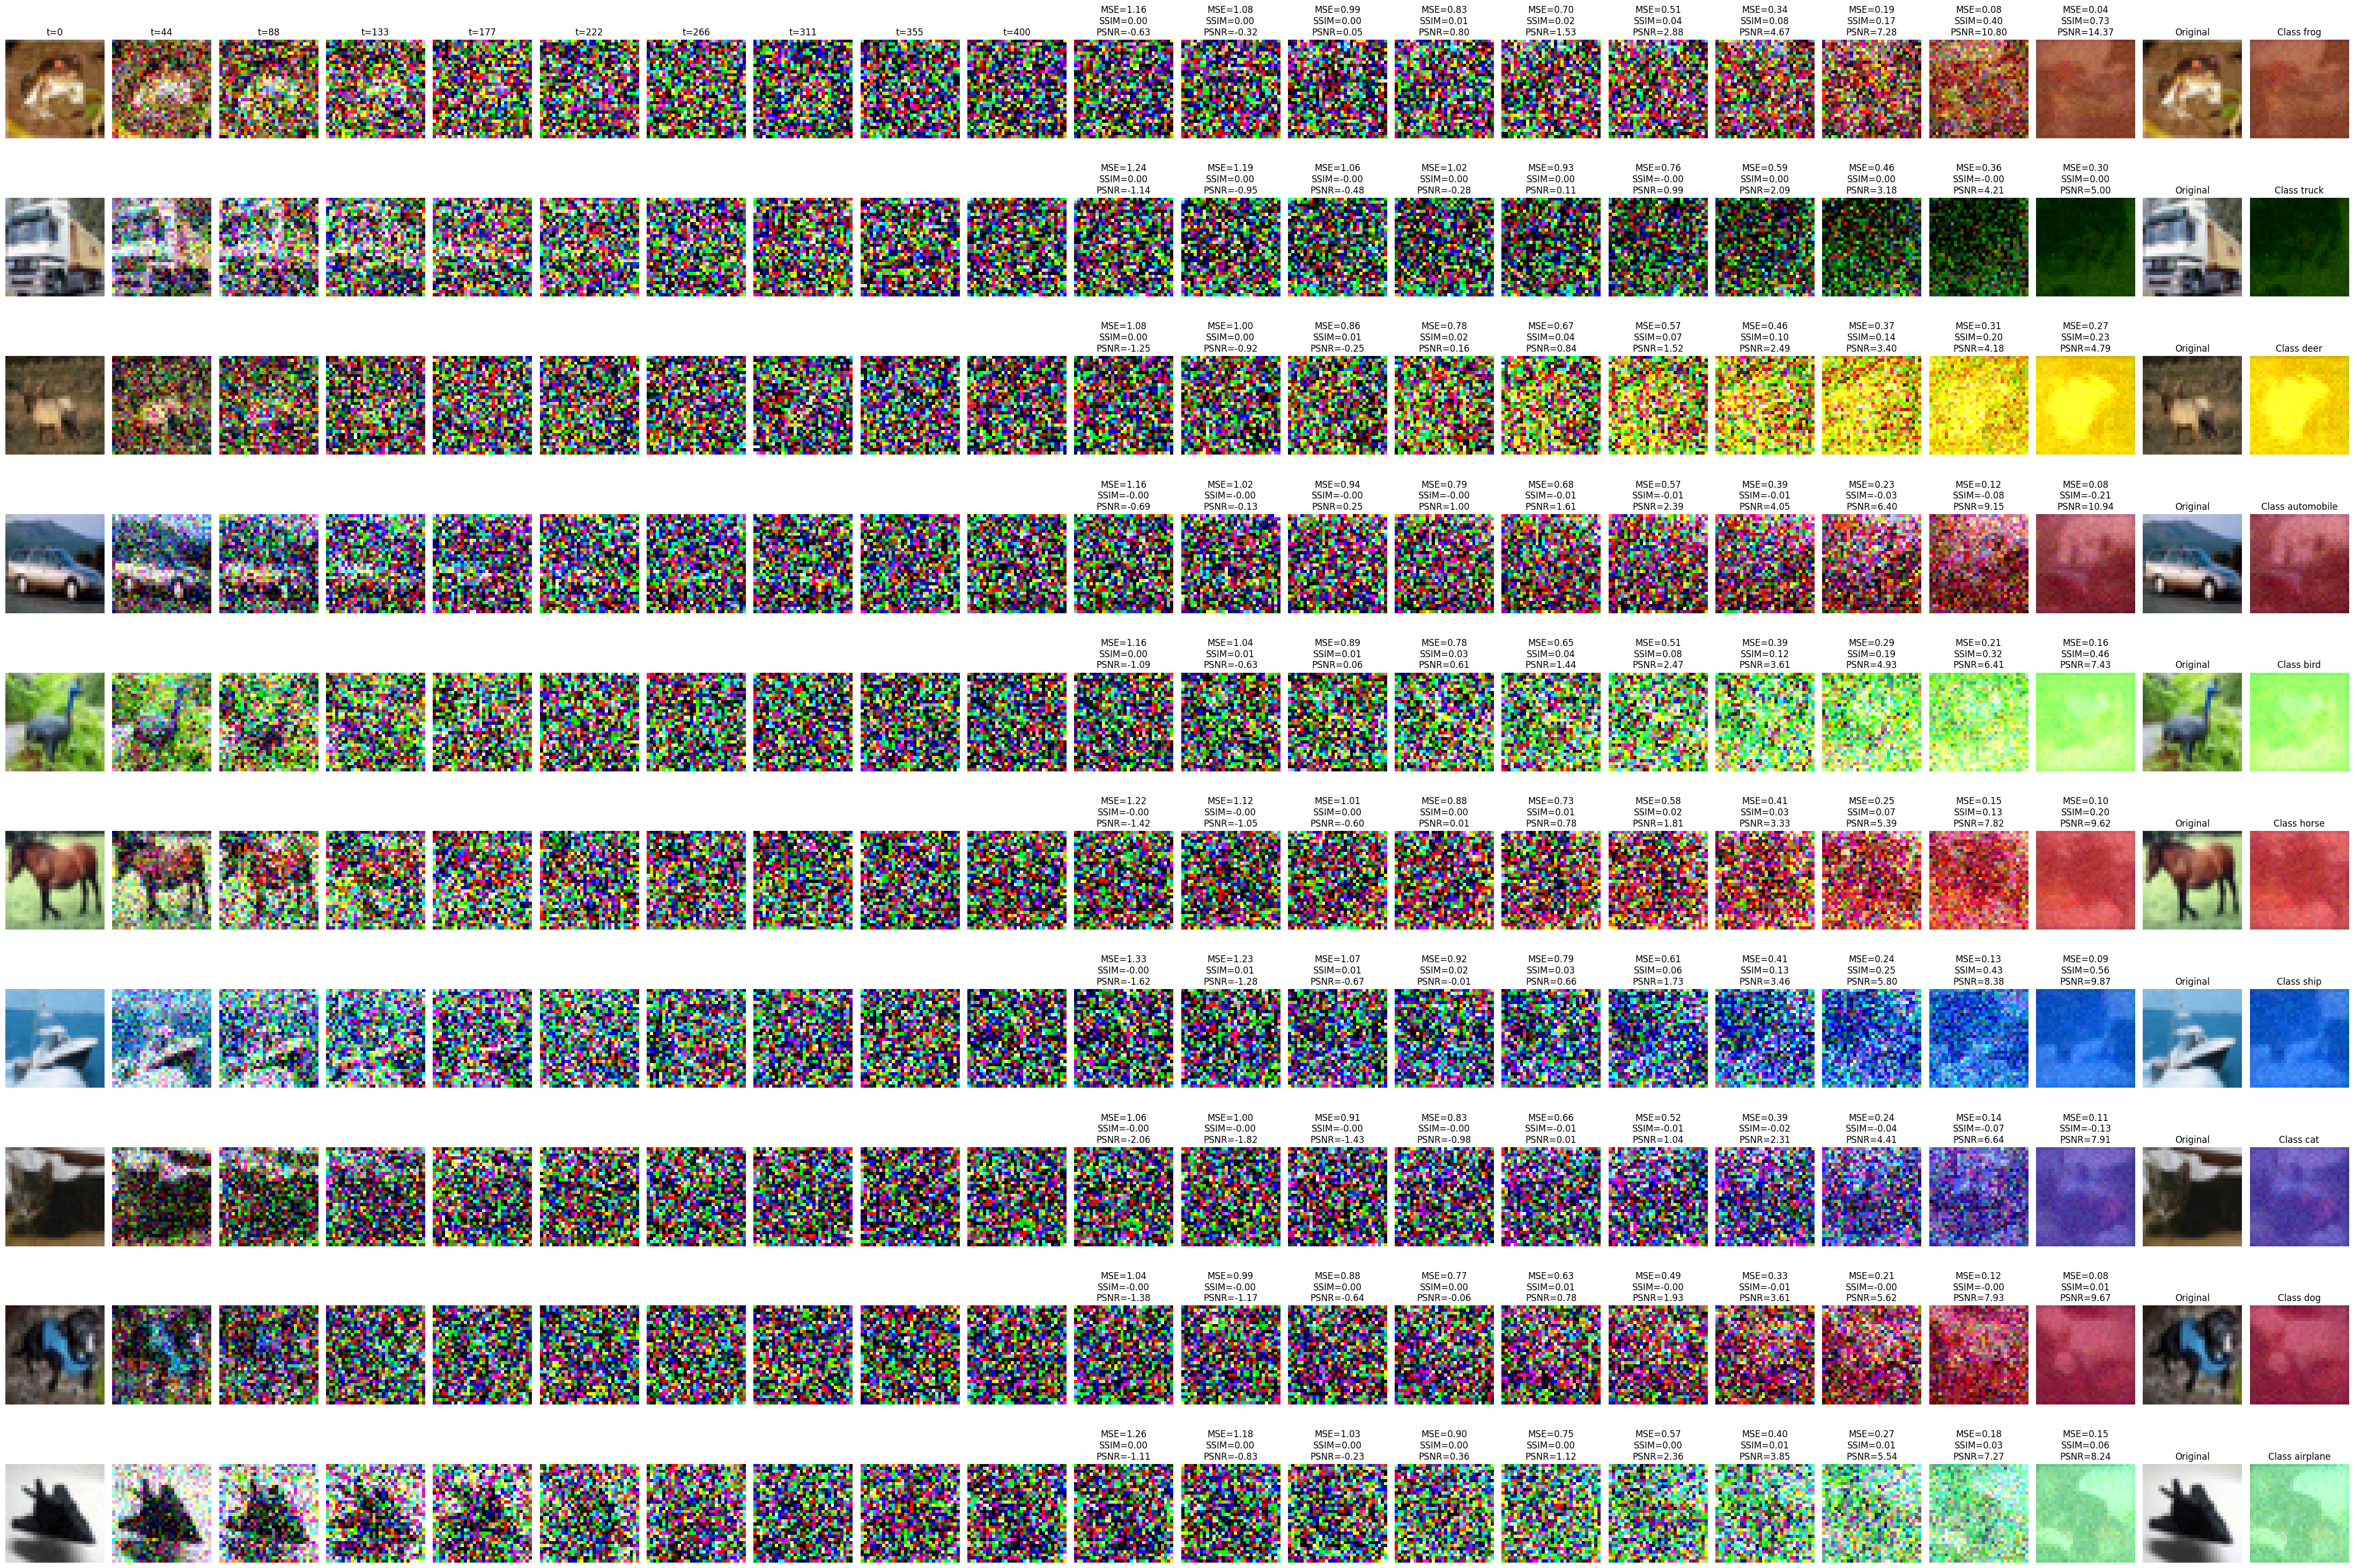

In [15]:
plot_samples_per_class(ddpm, train, class_names)

In [16]:
plot_samples_per_class(ddpm, test, class_names)

In [27]:
def plot_average_metrics(ddpm, train_dataset, test_dataset, class_names, n_samples=3, random_selection=False):
    """
    Compute and plot average metrics (MSE, SSIM, PSNR) for 3 samples per class
    for both train and test datasets, and visualize the ground truth and generated samples.

    Parameters:
    - ddpm: The trained DDPM model.
    - train_dataset: The training dataset.
    - test_dataset: The testing dataset.
    - class_names: List of class names for CIFAR-10.
    - n_samples: Number of samples per class to evaluate.
    - random_selection: Whether to select samples randomly or always use the first n_samples.
    """
    import random
    from collections import defaultdict
    import matplotlib.pyplot as plt

    def compute_metrics_and_samples(dataset, dataset_type):
        metrics = defaultdict(lambda: {'mse': [], 'ssim': [], 'psnr': []})
        samples = defaultdict(lambda: {'original': [], 'generated': []})

        for class_idx in range(len(class_names)):
            class_samples = [img for img, label in dataset if label == class_idx]
            
            if random_selection:
                selected_samples = random.sample(class_samples, min(n_samples, len(class_samples)))
            else:
                selected_samples = class_samples[:min(n_samples, len(class_samples))]

            for img in selected_samples:
                img = img.unsqueeze(0).to(ddpm.device)
                timesteps = np.linspace(0, ddpm.n_T, 10, dtype=int)

                # Forward and backward process
                with torch.no_grad():
                    x_t = img.clone()
                    for t in timesteps:
                        noise = torch.randn_like(img).to(ddpm.device)
                        beta = ddpm.sqrtmab[t]
                        alpha = ddpm.sqrtab[t]
                        x_t = alpha * img + beta * noise
                    
                    # Backward process starts with noisy image
                    for t in reversed(range(1, ddpm.n_T + 1)):
                        z = torch.randn_like(x_t).to(ddpm.device) if t > 1 else 0
                        eps = ddpm.nn_model(x_t, torch.tensor([class_idx]).to(ddpm.device),
                                            torch.tensor([t / ddpm.n_T]).to(ddpm.device),
                                            torch.tensor([0]).to(ddpm.device))
                        x_t = ddpm.oneover_sqrta[t] * (x_t - eps * ddpm.mab_over_sqrtmab[t]) + ddpm.sqrt_beta_t[t] * z
                
                # Compute metrics
                original = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
                reconstructed = x_t.squeeze(0).permute(1, 2, 0).cpu().numpy()

                mse = np.mean((original - reconstructed) ** 2)
                ssim_val = ssim(original, reconstructed, multichannel=True, data_range=original.max() - original.min(), win_size=3)
                psnr_val = psnr(original, reconstructed, data_range=original.max() - original.min())

                metrics[class_idx]['mse'].append(mse)
                metrics[class_idx]['ssim'].append(ssim_val)
                metrics[class_idx]['psnr'].append(psnr_val)

                # Store original and generated samples
                samples[class_idx]['original'].append(original)
                samples[class_idx]['generated'].append(reconstructed)
        
        # Compute averages
        for class_idx in metrics:
            metrics[class_idx]['mse'] = np.mean(metrics[class_idx]['mse'])
            metrics[class_idx]['ssim'] = np.mean(metrics[class_idx]['ssim'])
            metrics[class_idx]['psnr'] = np.mean(metrics[class_idx]['psnr'])
        
        return metrics, samples

    # Compute metrics and samples for train and test datasets
    train_metrics, train_samples = compute_metrics_and_samples(train_dataset, "Train")
    test_metrics, test_samples = compute_metrics_and_samples(test_dataset, "Test")

    # Plot metrics
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    metric_names = ['MSE', 'SSIM', 'PSNR']
    for i, metric in enumerate(metric_names):
        train_values = [train_metrics[c][metric.lower()] for c in range(len(class_names))]
        test_values = [test_metrics[c][metric.lower()] for c in range(len(class_names))]

        axes[i].bar(class_names, train_values, alpha=0.6, label='Train', color='blue')
        axes[i].bar(class_names, test_values, alpha=0.6, label='Test', color='orange')
        axes[i].set_title(f'Average {metric} per Class')
        axes[i].set_ylabel(metric)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    # Visualize samples
    for class_idx, class_name in enumerate(class_names):
        fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
        fig.suptitle(f'{class_name} Samples: Original (Top) vs Generated (Bottom)', fontsize=16)
        
        for i in range(n_samples):
            if i < len(train_samples[class_idx]['original']):
                axes[0, i].imshow(train_samples[class_idx]['original'][i])
                axes[0, i].axis('off')
                axes[1, i].imshow(train_samples[class_idx]['generated'][i])
                axes[1, i].axis('off')

        plt.show()

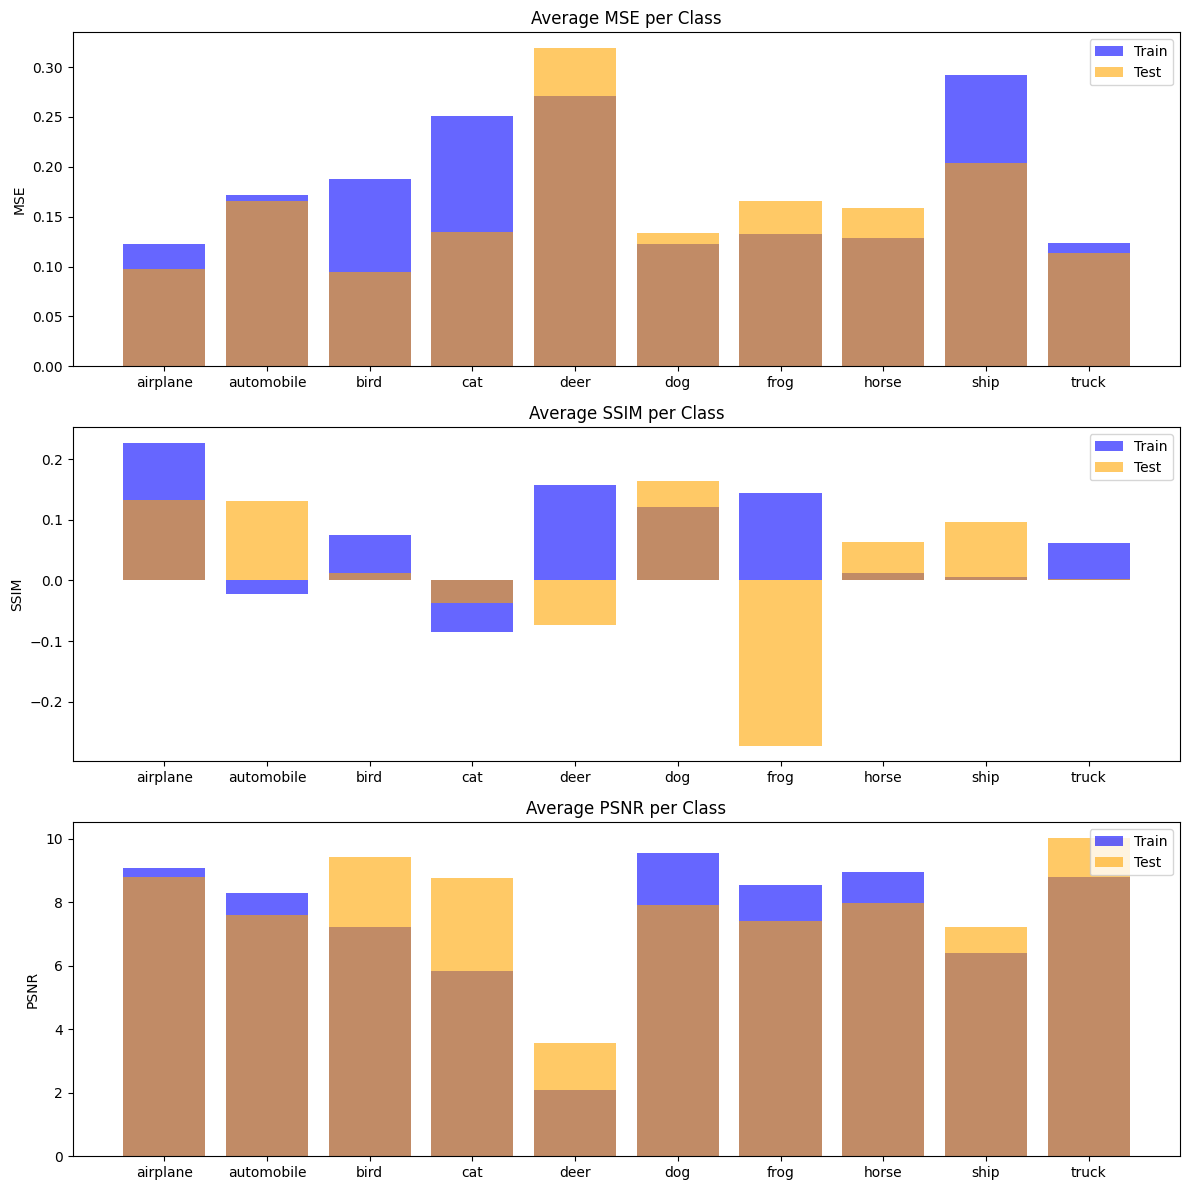

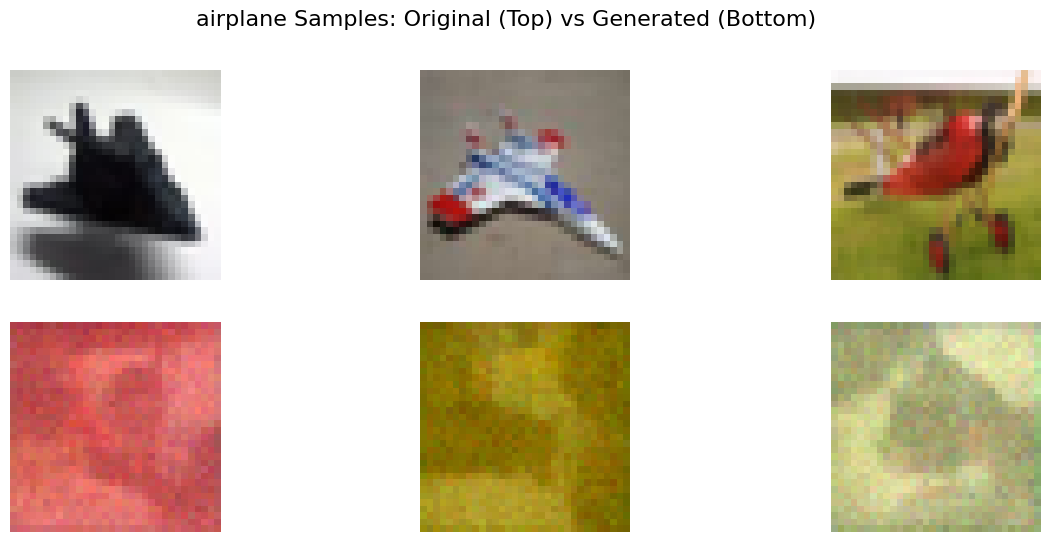

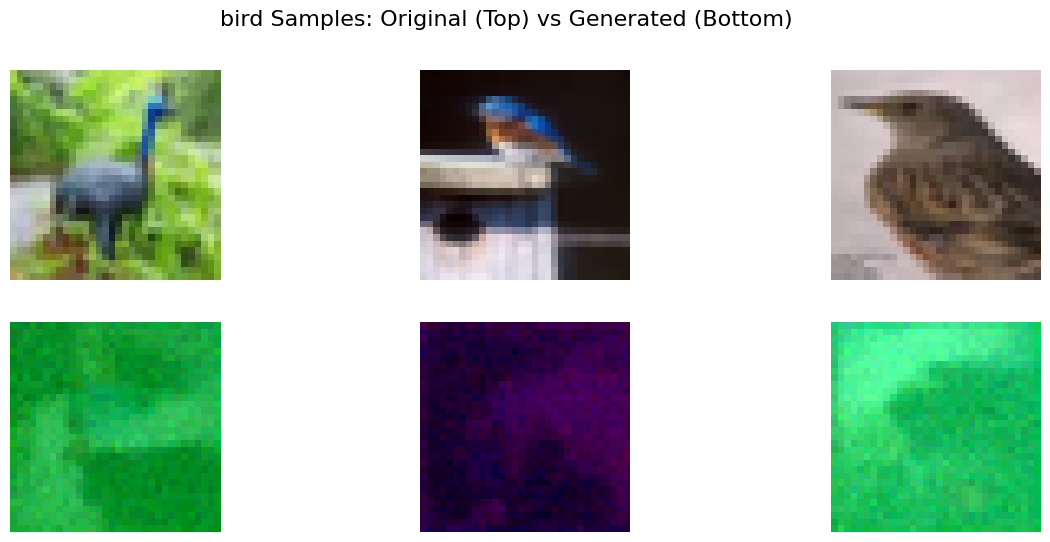

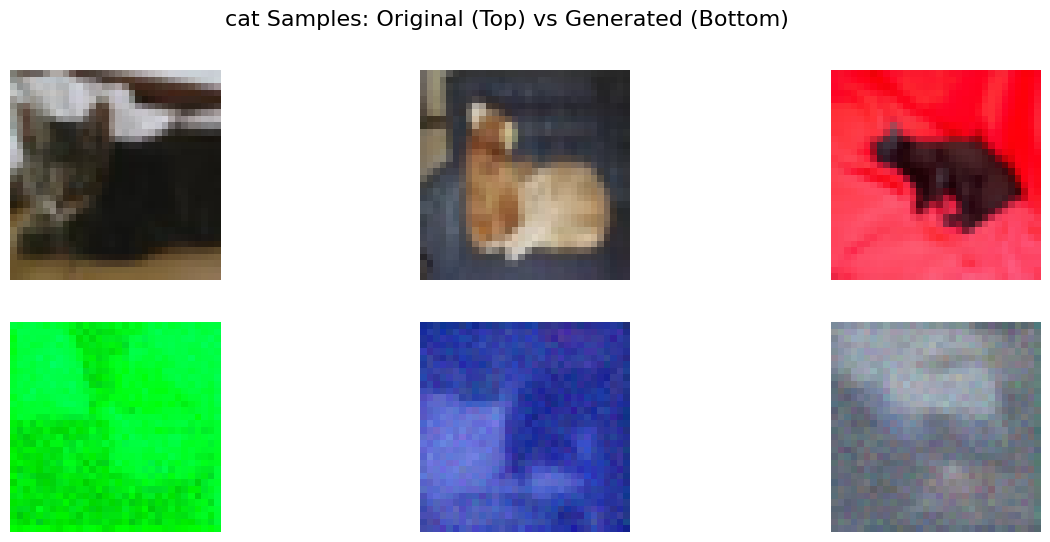

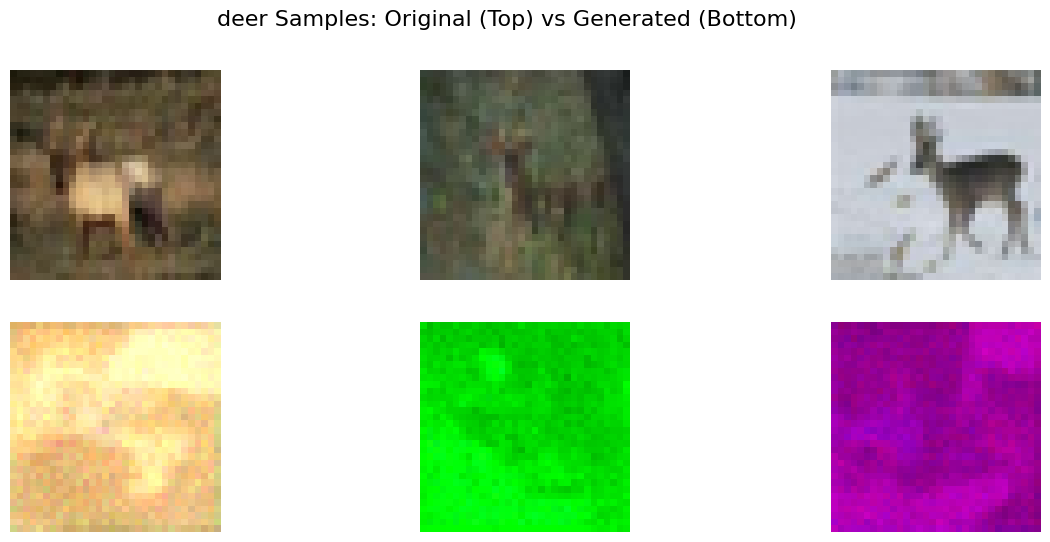

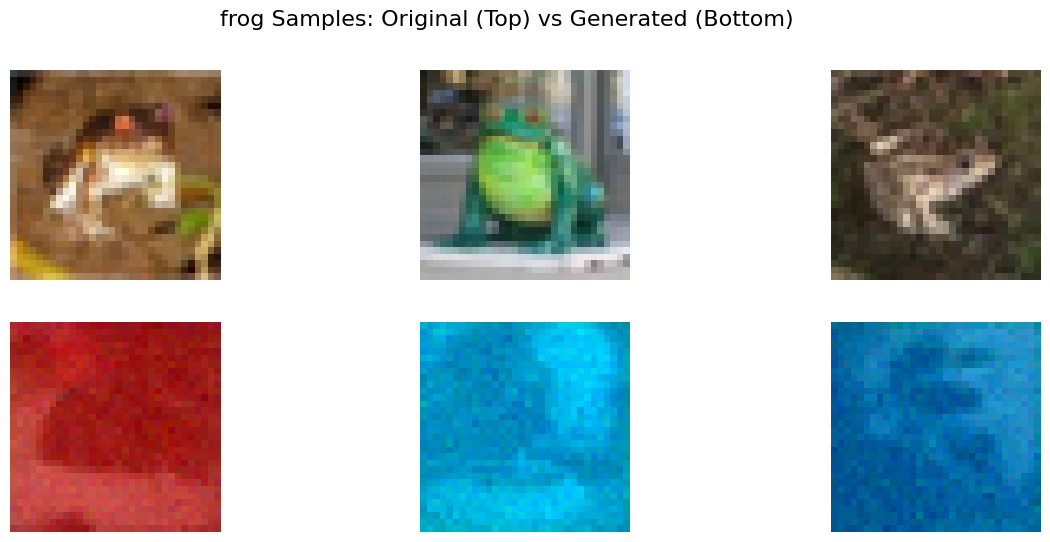

In [25]:
plot_average_metrics(ddpm, train, test, class_names)


In [28]:
def plot_impact_of_step_size_and_noise(ddpm, dataset, step_sizes, noise_levels, class_name='airplane', class_index=0, n_samples=3, random_selection=False):
    """
    Plot the impact of step size and amount of noise added on the quality metrics (MSE, SSIM, PSNR)
    as both scatter plots and heatmaps with values in cells.

    Parameters:
    - ddpm: The trained DDPM model.
    - dataset: The dataset to evaluate.
    - step_sizes: List of step sizes to evaluate.
    - noise_levels: List of noise levels to evaluate.
    - class_name: Name of the class to evaluate.
    - class_index: Index of the class to evaluate.
    - n_samples: Number of samples to evaluate.
    - random_selection: Whether to select samples randomly or always use the first n_samples.
    """
    import random
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    metrics = {'mse': np.zeros((len(noise_levels), len(step_sizes))),
               'ssim': np.zeros((len(noise_levels), len(step_sizes))),
               'psnr': np.zeros((len(noise_levels), len(step_sizes)))}

    class_samples = [img for img, label in dataset if label == class_index]
    
    # Select samples based on the random_selection flag
    if random_selection:
        selected_samples = random.sample(class_samples, min(n_samples, len(class_samples)))
    else:
        selected_samples = class_samples[:min(n_samples, len(class_samples))]

    for i, noise_level in enumerate(noise_levels):
        for j, step_size in enumerate(step_sizes):
            mse_values, ssim_values, psnr_values = [], [], []

            for img in selected_samples:
                img = img.unsqueeze(0).to(ddpm.device)

                # Forward and backward process with adjusted step size and noise level
                timesteps = np.arange(0, ddpm.n_T, step_size, dtype=int)
                with torch.no_grad():
                    x_t = img.clone()
                    for t in timesteps:
                        noise = torch.randn_like(img).to(ddpm.device) * noise_level
                        beta = ddpm.sqrtmab[t]
                        alpha = ddpm.sqrtab[t]
                        x_t = alpha * img + beta * noise

                    for t in reversed(range(1, ddpm.n_T + 1)):
                        z = torch.randn_like(x_t).to(ddpm.device) if t > 1 else 0
                        eps = ddpm.nn_model(x_t, torch.tensor([class_index]).to(ddpm.device),
                                            torch.tensor([t / ddpm.n_T]).to(ddpm.device),
                                            torch.tensor([0]).to(ddpm.device))
                        x_t = ddpm.oneover_sqrta[t] * (x_t - eps * ddpm.mab_over_sqrtmab[t]) + ddpm.sqrt_beta_t[t] * z

                # Compute metrics
                original = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
                reconstructed = x_t.squeeze(0).permute(1, 2, 0).cpu().numpy()

                mse_values.append(np.mean((original - reconstructed) ** 2))
                ssim_values.append(ssim(original, reconstructed, multichannel=True, data_range=original.max() - original.min(), win_size=3))
                psnr_values.append(psnr(original, reconstructed, data_range=original.max() - original.min()))

            # Store average metrics for this combination
            metrics['mse'][i, j] = np.mean(mse_values)
            metrics['ssim'][i, j] = np.mean(ssim_values)
            metrics['psnr'][i, j] = np.mean(psnr_values)

    # Scatter plots
    fig_scatter, axes_scatter = plt.subplots(3, 1, figsize=(10, 15))
    metric_names = ['mse', 'ssim', 'psnr']
    for k, metric in enumerate(metric_names):
        for step_size in step_sizes:
            indices = [j for j, s in enumerate(step_sizes) if s == step_size]
            axes_scatter[k].plot(
                noise_levels,
                metrics[metric][:, indices[0]],
                marker='o',
                label=f'Step Size {step_size}'
            )
        axes_scatter[k].set_title(f'Impact on {metric.upper()}')
        axes_scatter[k].set_xlabel('Noise Level')
        axes_scatter[k].set_ylabel(metric.upper())
        axes_scatter[k].legend()

    plt.tight_layout()
    plt.show()

    # Heatmaps
    fig_heatmap, axes_heatmap = plt.subplots(1, 3, figsize=(18, 6))
    for k, metric in enumerate(metric_names):
        sns.heatmap(
            metrics[metric],
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            xticklabels=step_sizes,
            yticklabels=noise_levels,
            ax=axes_heatmap[k],
            cbar_kws={'label': metric.upper()},
            norm=Normalize(vmin=np.min(metrics[metric]), vmax=np.max(metrics[metric]))
        )
        axes_heatmap[k].set_title(f'{metric.upper()} Heatmap')
        axes_heatmap[k].set_xlabel('Step Sizes')
        axes_heatmap[k].set_ylabel('Noise Levels')

    plt.suptitle(f'Impact of Step Size and Noise on Metrics ({class_name})', fontsize=16)
    plt.tight_layout()
    plt.show()

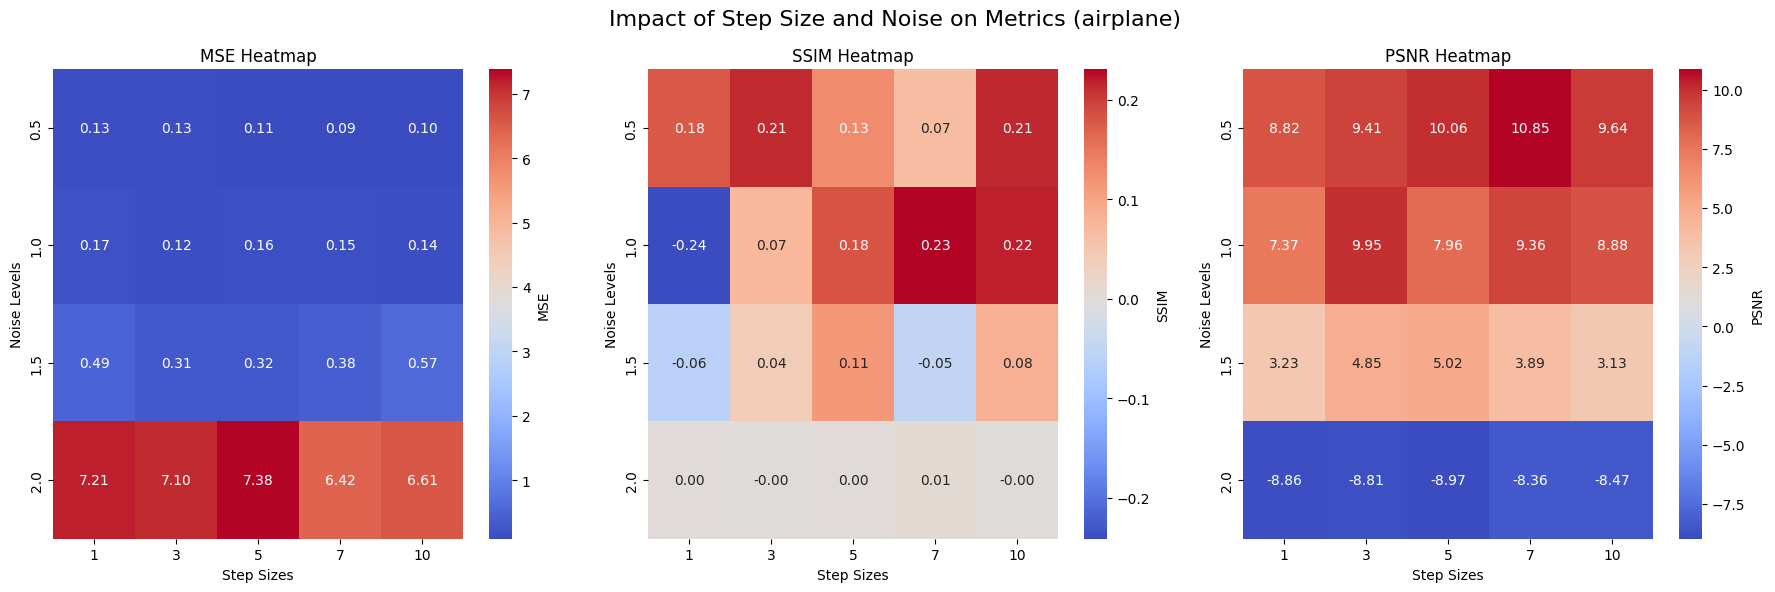

In [29]:
step_sizes = [1, 3, 5, 7, 10]
noise_levels = [0.5, 1.0, 1.5, 2.0]
plot_impact_of_step_size_and_noise(ddpm, train, step_sizes, noise_levels, class_name='airplane', class_index=0)

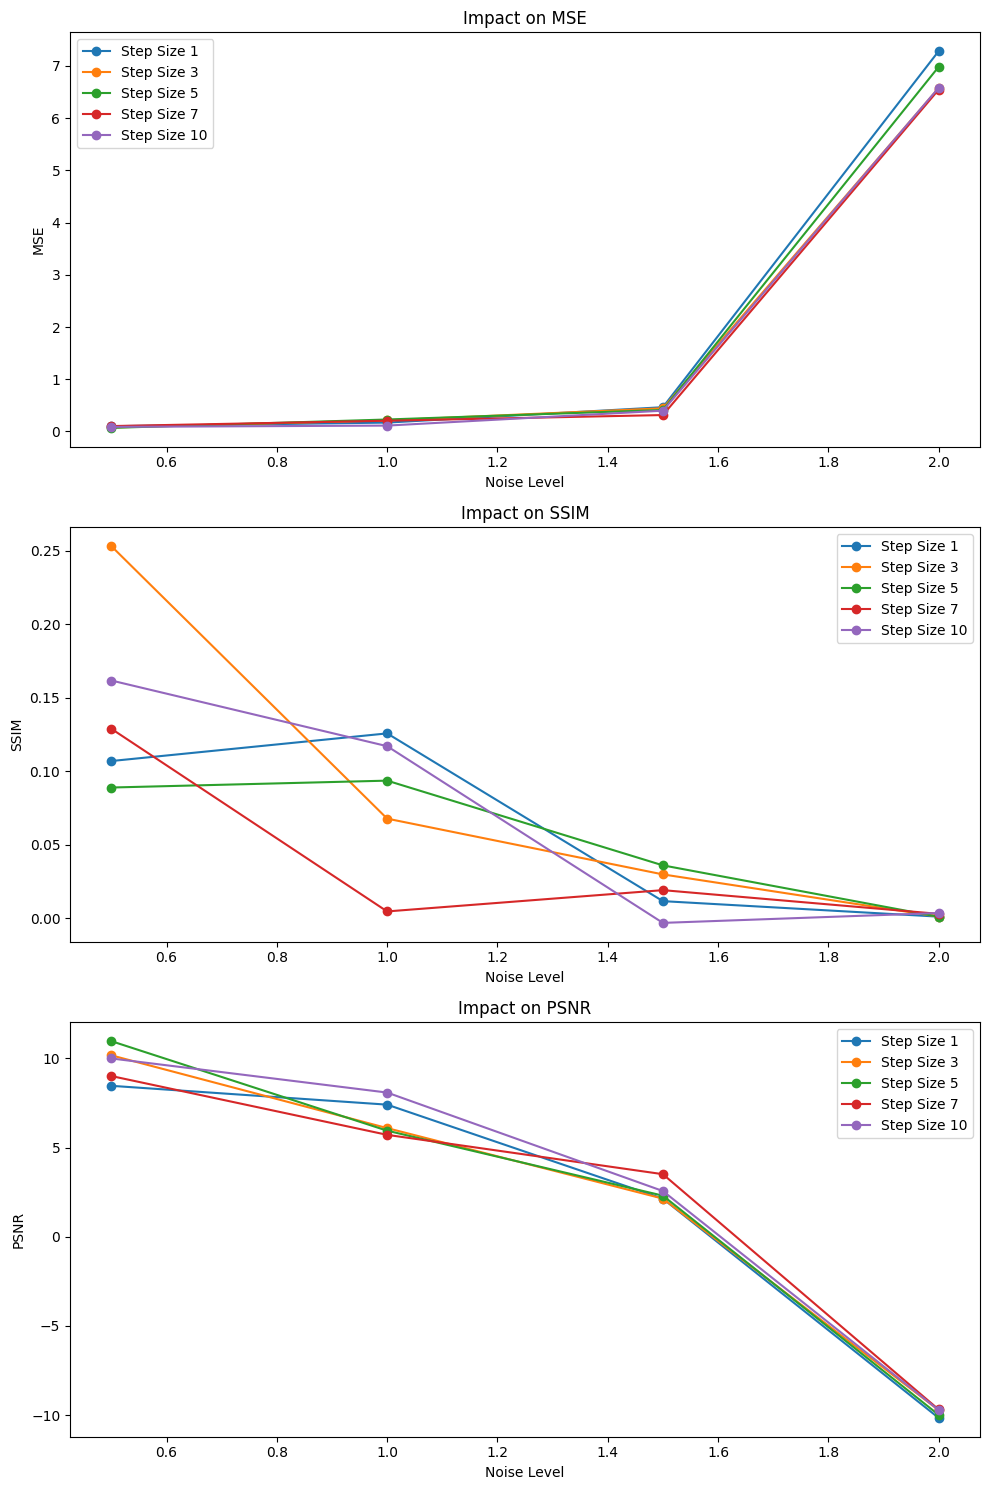

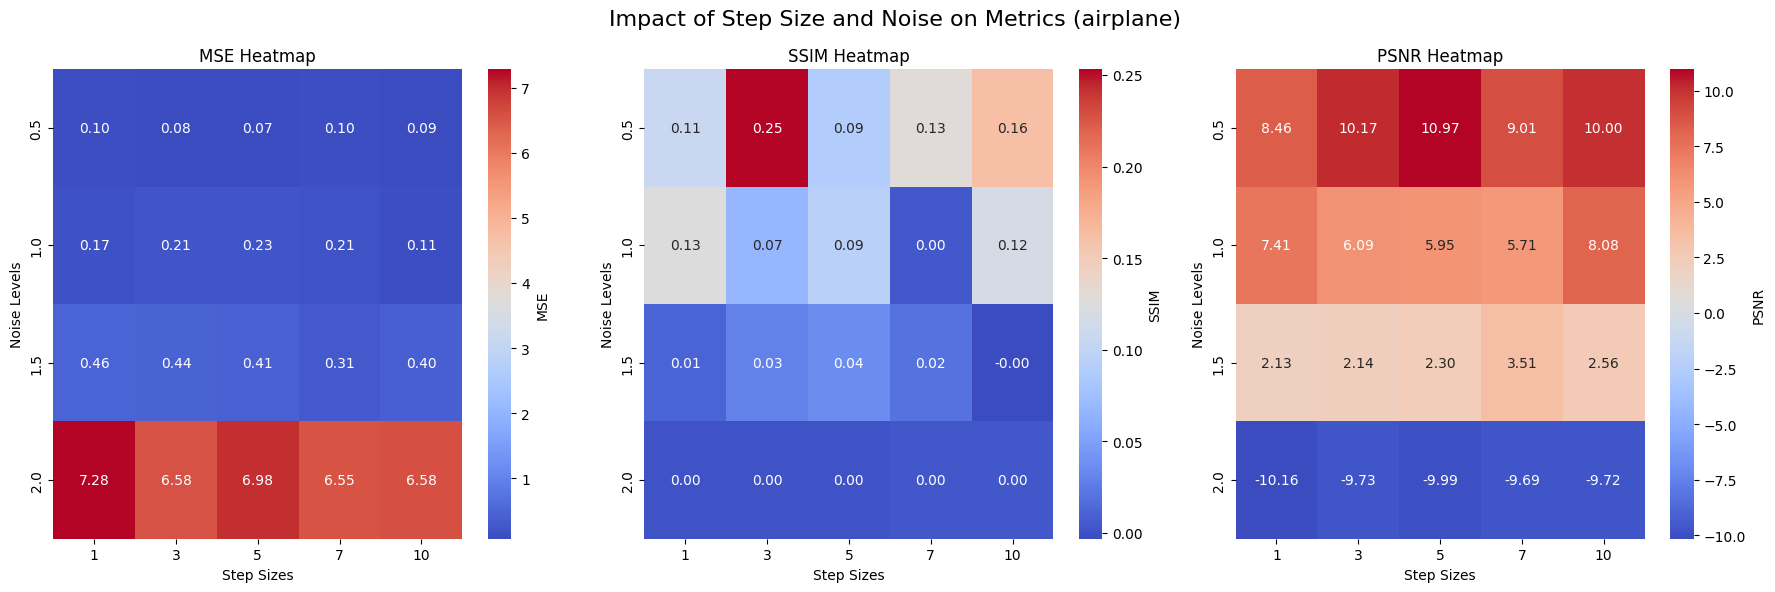

In [30]:
step_sizes = [1, 3, 5, 7, 10]
noise_levels = [0.5, 1.0, 1.5, 2.0]
plot_impact_of_step_size_and_noise(ddpm, test, step_sizes, noise_levels, class_name='airplane', class_index=0)

In [22]:
def generate_and_plot_samples(ddpm, class_names, n_samples=3):
    """
    Generate and plot samples for each class using the trained DDPM model.

    Parameters:
    - ddpm: The trained DDPM model.
    - class_names: List of class names for CIFAR-10.
    - n_samples: Number of samples to generate per class.
    """
    fig, axes = plt.subplots(n_samples, len(class_names), figsize=(len(class_names) * 3, n_samples * 3))

    for sample_idx in range(n_samples):
        for class_idx, class_name in enumerate(class_names):
            with torch.no_grad():
                # Generate initial noise
                x_t = torch.randn(1, 3, 32, 32).to(ddpm.device)

                for t in reversed(range(1, ddpm.n_T + 1)):
                    z = torch.randn_like(x_t).to(ddpm.device) if t > 1 else 0
                    eps = ddpm.nn_model(x_t, torch.tensor([class_idx]).to(ddpm.device),
                                        torch.tensor([t / ddpm.n_T]).to(ddpm.device),
                                        torch.tensor([0]).to(ddpm.device))
                    x_t = ddpm.oneover_sqrta[t] * (x_t - eps * ddpm.mab_over_sqrtmab[t]) + ddpm.sqrt_beta_t[t] * z

                # Plot the generated image
                img = x_t.squeeze(0).permute(1, 2, 0).cpu().numpy()
                axes[sample_idx, class_idx].imshow((img - img.min()) / (img.max() - img.min()))
                axes[sample_idx, class_idx].axis('off')

            if sample_idx == 0:
                axes[sample_idx, class_idx].set_title(class_name, size='large')

    plt.tight_layout()
    plt.show()

In [23]:
generate_and_plot_samples(ddpm, class_names, n_samples=5)